## Part 1 Time Series Analysis

In [23]:
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

### Stationarity
Differences need to be applied if data is not stationary.

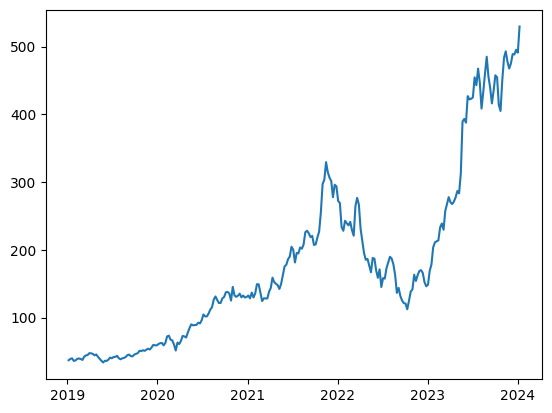

In [24]:
ticker = yf.Ticker("NVDA")

# get all stock info
# msft.info

# get historical market data
df = ticker.history(period='5y', interval='1wk')
df = df[['Close']]
plt.plot(df)

In [25]:
df.head(10)

,Close
Date,
2019-01-07 00:00:00-05:00,36.918488
2019-01-14 00:00:00-05:00,38.927750
2019-01-21 00:00:00-05:00,39.726521
2019-01-28 00:00:00-05:00,35.901451
2019-02-04 00:00:00-05:00,36.754772
2019-02-11 00:00:00-05:00,39.029472
2019-02-18 00:00:00-05:00,39.488373
2019-02-25 00:00:00-05:00,38.808689
2019-03-04 00:00:00-05:00,37.405991


The adfuller test can help us do hypothesis testing on the stationarity

In [26]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(df):
    result=adfuller(df)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    print('Ho: Data is non-stationary')
    print('H1: Data is stationary')
    print()
    if result[1] <= 0.05:
        print("p < 0.05, strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("p > 0.05, weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df)

ADF Test Statistic : 0.8340969006569101
p-value : 0.9921670883362239
#Lags Used : 9
Number of Observations : 252
Ho: Data is non-stationary
H1: Data is stationary

p > 0.05, weak evidence against null hypothesis,indicating it is non-stationary 


Look at the differences, taking the first order of difference will give us stationarity

In [27]:
first_order_difference = df - df.shift(1)
adfuller_test(first_order_difference.dropna())

ADF Test Statistic : -4.750660032562462
p-value : 6.752376660201544e-05
#Lags Used : 8
Number of Observations : 252
Ho: Data is non-stationary
H1: Data is stationary

p < 0.05, strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


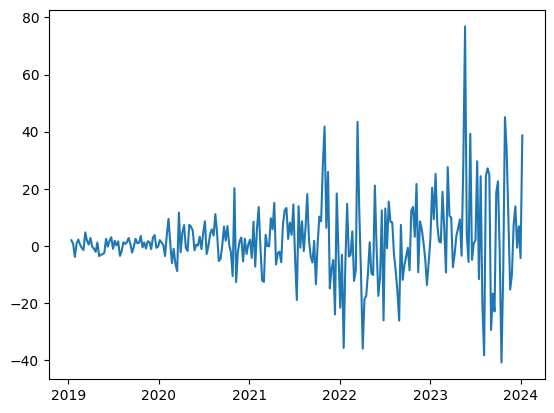

In [28]:
plt.plot(first_order_difference.index, first_order_difference.values)

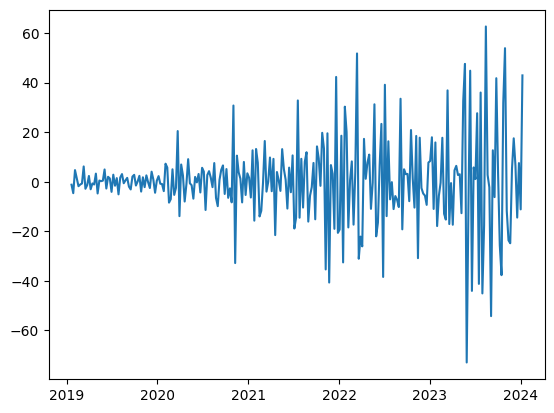

In [29]:
second_order_difference = first_order_difference - first_order_difference.shift(1)
plt.plot(second_order_difference.index, second_order_difference.values)

### Autocorrelation
We should plot autocorrelation based on the differences that we plan to use.

Note that this is on the actual values, it will only be useful if we are using d = 0

The autocorrelation plot shows the correlation between $y_t$ and $y_{t-k}$ with all the influencing variables removed. Here is an explanation from stack exchange
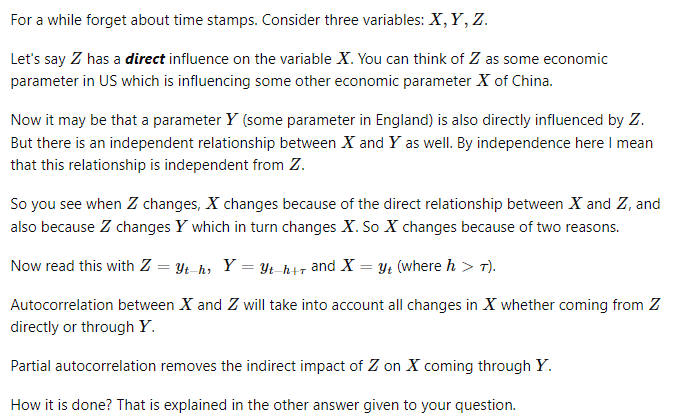



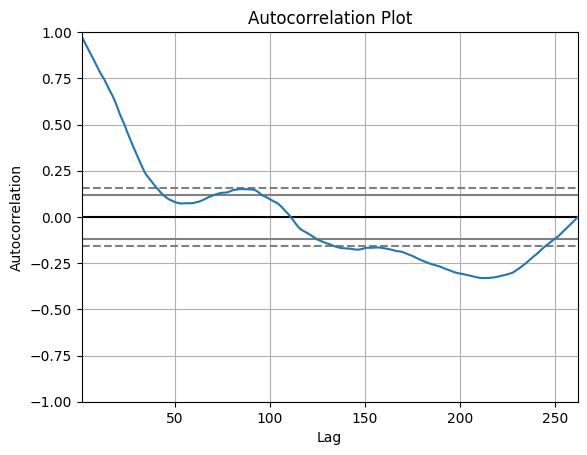

In [30]:
from pandas.plotting import autocorrelation_plot

ax = autocorrelation_plot(df)
ax.set_title('Autocorrelation Plot')
# ax.set_xlim(right=365)
# ax.set_ylim(bottom=0.5)
plt.show()

We can also use statsmodels' library

This time use the first order of difference, removed lag of 0 (the same value itself will have correlation of 1)

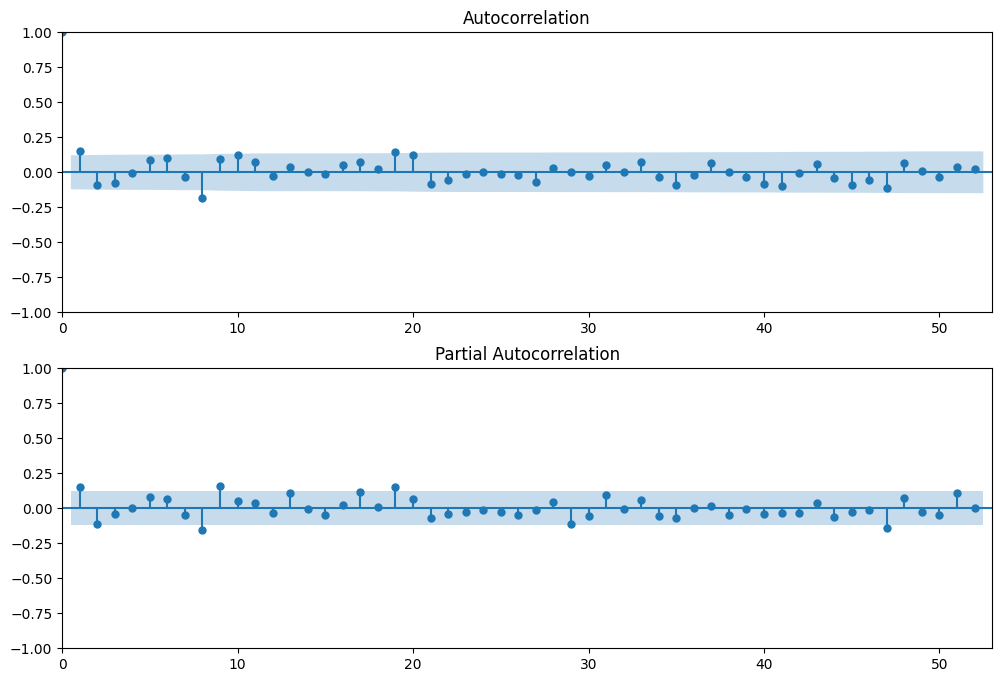

In [31]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
lags = 52

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax1.set_xlim(left=0, right = lags+1)
fig = sm.graphics.tsa.plot_acf(first_order_difference.dropna(),lags=lags,ax=ax1)

ax2 = fig.add_subplot(212)
ax2.set_xlim(left=0, right = lags+1)
fig = sm.graphics.tsa.plot_pacf(first_order_difference.dropna(),lags=lags,ax=ax2)

### pdq of ARIMA
p: The lag order, representing the number of lag observations incorporated in the model.

d: Degree of differencing, denoting the number of times raw observations undergo differencing.

q: Order of moving average, indicating the size of the moving average window.


In [32]:
# We need the index to be periods for ARIMA
time_series = df.copy()
time_series.index = time_series.index.to_period('W') 
# Doing this conversion on daily interval will mess up our dates because the original data did not include weekend dates

C:\Users\stell\AppData\Local\Temp\ipykernel_8076\549776980.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  time_series.index = time_series.index.to_period('W')


In [33]:
p = 1
d = 1 # From the graph above, data is not stationary, we will apply difference of 1
q = 1 

model = ARIMA(time_series, order=(p, d, q))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  262
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1044.962
Date:                Wed, 10 Jan 2024   AIC                           2095.925
Time:                        00:42:43   BIC                           2106.618
Sample:                    01-13-2019   HQIC                          2100.223
                         - 01-14-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1836      0.223     -0.823      0.410      -0.621       0.254
ma.L1          0.3787      0.210      1.804      0.071      -0.033       0.790
sigma2       175.7956      9.479     18.546      0.0

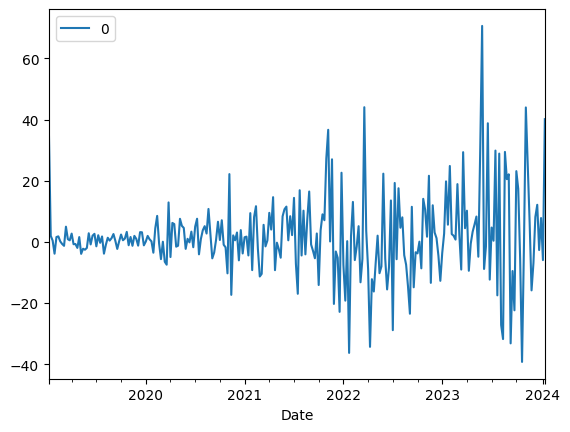

In [34]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

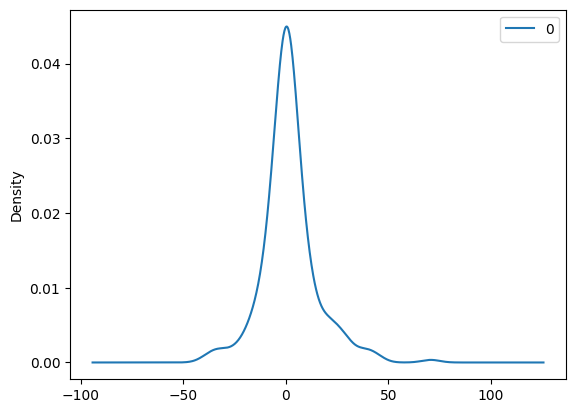

                0
count  262.000000
mean     1.777973
std     13.335876
min    -39.237586
25%     -4.058033
50%      0.679997
75%      5.804309
max     70.639784


In [35]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [36]:
evaluation = time_series.copy()
evaluation['fitted_values'] = model_fit.fittedvalues
# in_sample_predictions = model_fit.predict(start=1, end = 262, dynamic=False) # This is similar to fittedvalues
evaluation['residuals'] = model_fit.resid[1:]
evaluation

,Close,fitted_values,residuals
Date,,,
2019-01-07/2019-01-13,36.918488,0.000000,NaN
2019-01-14/2019-01-20,38.927750,36.919706,2.008043
2019-01-21/2019-01-27,39.726521,39.290430,0.436091
2019-01-28/2019-02-03,35.901451,39.744109,-3.842658
2019-02-04/2019-02-10,36.754772,35.149762,1.605010
...,...,...,...
2023-12-11/2023-12-17,488.899994,476.750883,12.149111
2023-12-18/2023-12-24,488.299988,490.951803,-2.651816
2023-12-25/2023-12-31,495.220001,487.405992,7.814010


In [37]:
import numpy as np

def MSE(y, yhat, p):
    '''
    Calculate MSE, ignores the lag periods at the start
    '''
    y = y[p:]
    yhat = yhat[p:]
    return round(1/len(y)*(np.sum(y-yhat))**2, 3)

mse = MSE(evaluation['Close'], evaluation['fitted_values'], p)
print(f'Mean squared error for fitted values : {mse}')

Mean squared error for fitted values : 704.843


In [38]:
len(model_fit.fittedvalues)

262

Notice that ARIMA does not incorporate Seasonality, it is unable forecast well especially on stock data which high seasonality

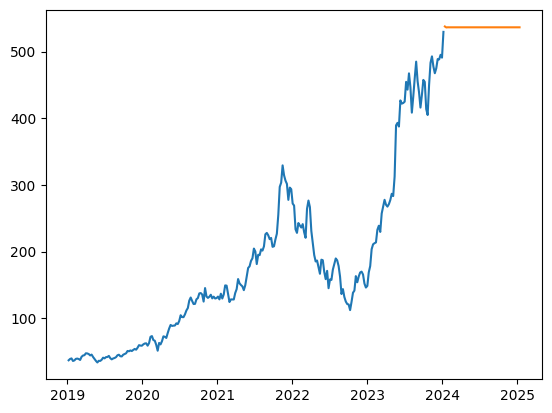

In [39]:
out_of_sample_predictions = model_fit.predict(start=len(df), end = len(df)+52, dynamic=False)
# Use .to_timestamp() to convert period back into timestamp for plotting
plt.plot(time_series.to_timestamp())
plt.plot(out_of_sample_predictions.to_timestamp())

## SARIMA - includes Seasonal Elements<br>
There are four seasonal elements that are not part of ARIMA that must be configured; they are:

P: Seasonal autoregressive order.<br>
D: Seasonal difference order.<br>
Q: Seasonal moving average order.<br>
m: The number of time steps for a single seasonal period.

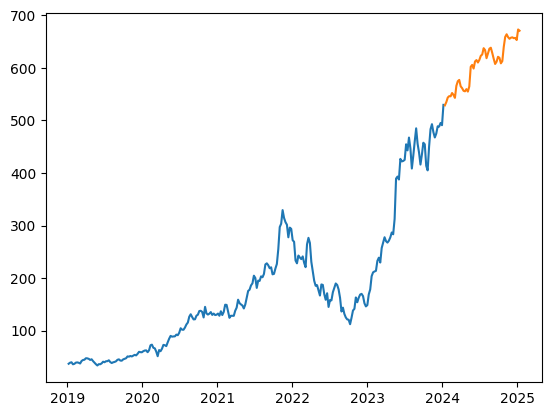

In [40]:
P = 1
D = 1
Q = 1
m = 52


# model = sm.tsa.statespace.SARIMAX(time_series, order=(p, d, q),seasonal_order=(P,D,Q,m))
model = ARIMA(time_series, order=(p, d, q),seasonal_order=(P,D,Q,m)) 

model_seasonality=model.fit()
out_of_sample_predictions = model_seasonality.predict(start=len(df), end = len(df)+52, dynamic=False)
# Use .to_timestamp() to convert period back into timestamp for plotting
plt.plot(time_series.to_timestamp())
plt.plot(out_of_sample_predictions.to_timestamp())

In [41]:
print(model_seasonality.summary())

                                    SARIMAX Results                                     
Dep. Variable:                            Close   No. Observations:                  262
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -874.882
Date:                          Wed, 10 Jan 2024   AIC                           1759.765
Time:                                  00:43:06   BIC                           1776.476
Sample:                              01-13-2019   HQIC                          1766.521
                                   - 01-14-2024                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0310      0.433     -0.072      0.943      -0.880       0.818
ma.L1          0.1732      0.431      0.402      0.

Lower MSE can be achieved with seasonality incorporated - AIC from 1700 for ARIMA to 1600 for SARIMA

In [42]:
mse = MSE(time_series.squeeze(), model_seasonality.fittedvalues, p)
print(f'Mean squared error for fitted values : {mse}')

Mean squared error for fitted values : 266.132


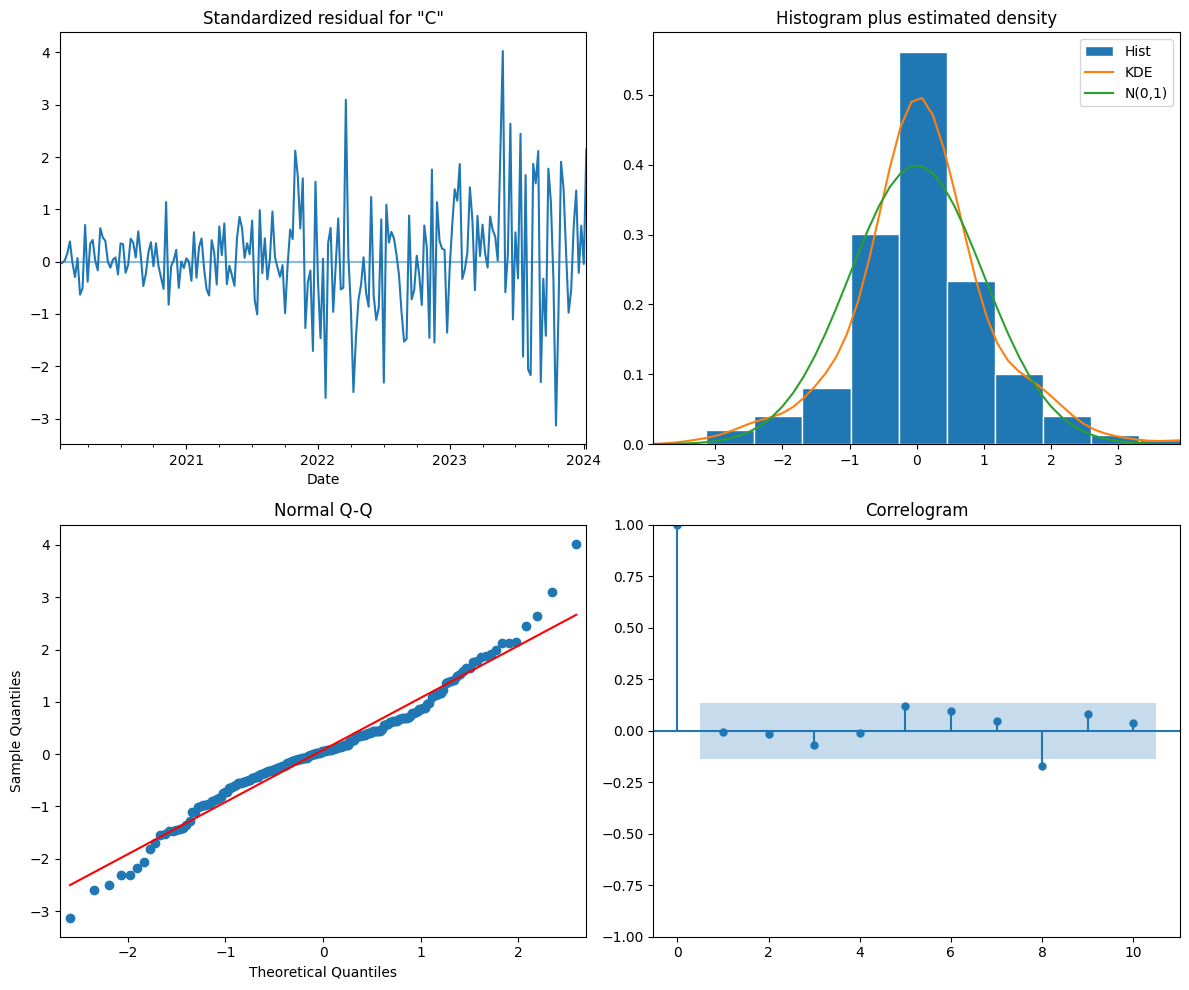

In [48]:
model_seasonality.plot_diagnostics(figsize=(12, 10))
plt.tight_layout()

## Faster way to determine best pdq and seasonal parameters
Note this has its own drawdowns, we need a good sensing of pdq and seasonal parameters still before determining the grid search

In [52]:
import pmdarima as pm

ticker = yf.Ticker("NVDA")
df = ticker.history(period='5y', interval='1wk')
ts = df[['High']]
ts.index = ts.index.to_period('W') 

# Create auto_arima model
auto_arima_model = pm.auto_arima(
        time_series,
        seasonal=True, 
        start_p=0, max_p=2,
        d=1,
        start_P=0, max_P=2,
        D=1,
        m=52,
        information_criterion='aic',
        trace=True,
        error_action='ignore',
        suppress_warnings=True)

# Print model summary
print(auto_arima_model.summary())

C:\Users\stell\AppData\Local\Temp\ipykernel_8076\3689981606.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  ts.index = ts.index.to_period('W')


Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,1,1)[52]             : AIC=inf, Time=12.31 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1798.770, Time=0.55 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=1765.182, Time=2.80 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=8.00 sec
 ARIMA(0,1,0)(2,1,0)[52]             : AIC=1759.165, Time=11.77 sec
 ARIMA(0,1,0)(2,1,1)[52]             : AIC=1761.101, Time=24.28 sec
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=1759.861, Time=15.00 sec
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=1757.048, Time=13.69 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1763.495, Time=3.75 sec
 ARIMA(0,1,1)(2,1,1)[52]             : AIC=1758.961, Time=40.03 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=1757.772, Time=17.26 sec
 ARIMA(0,1,2)(2,1,0)[52]             : AIC=1759.040, Time=18.49 sec
 ARIMA(0,1,1)(2,1,0)[52] intercept   : AIC=1757.710, Time=28.08 sec

Best model:  ARIMA(0,1,1)(2,1,0)[52]          
Total fit time: 196.092 seconds
       

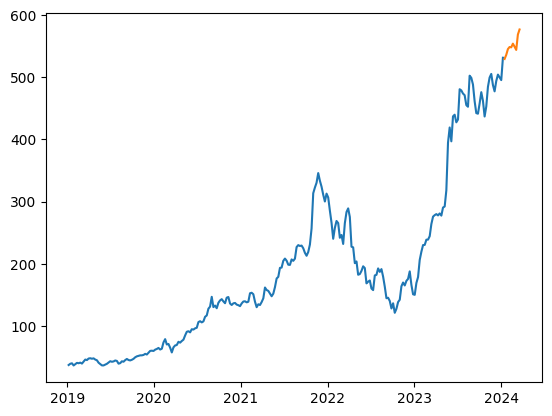

In [57]:
out_of_sample_predictions = auto_arima_model.predict(start=len(df), end = len(df)+52, dynamic=False)
# Use .to_timestamp() to convert period back into timestamp for plotting
plt.plot(ts.to_timestamp())
plt.plot(out_of_sample_predictions.to_timestamp())